In [41]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf
import math

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


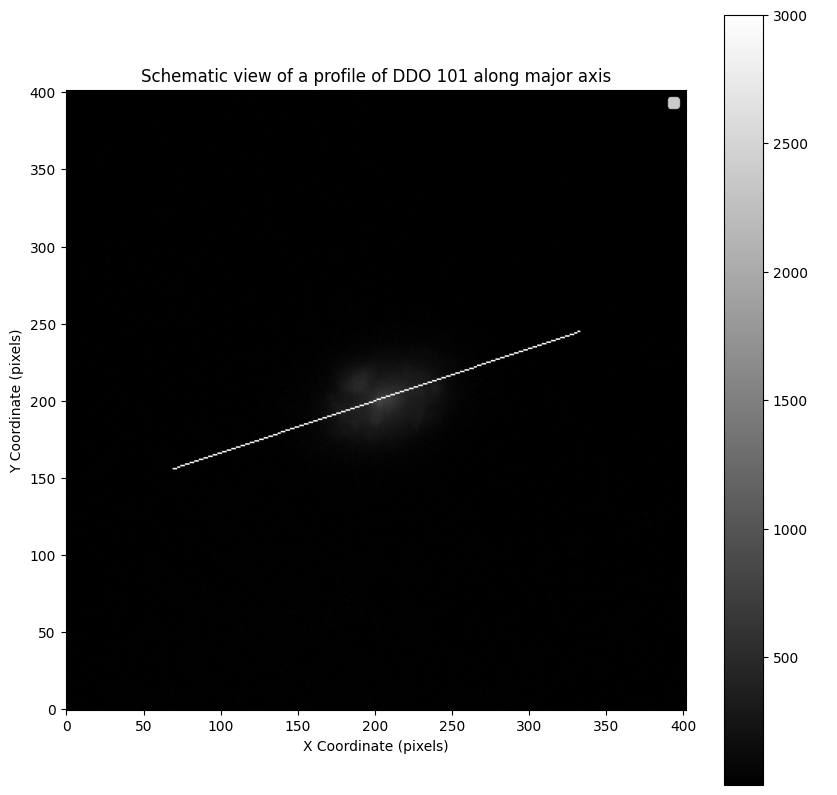

x_ax_left length: 132
x_ax_right length: 132
values_along_line_left length: 132
values_along_line_right length: 132
x_ax combined length: 264
values_along_line combined length: 264


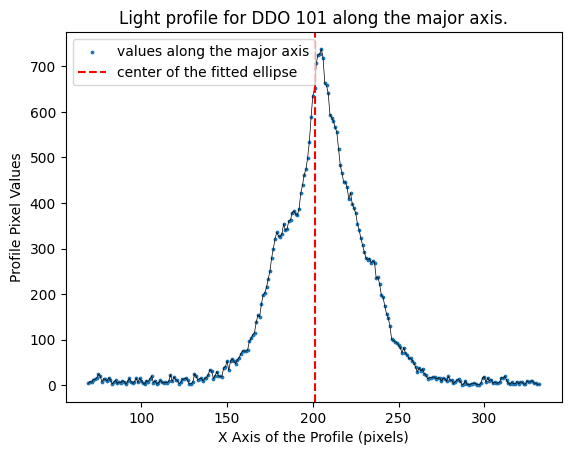

Threshold value: 325.58131654632496
Center of galaxy (Equal Area on both sides of the center line): 205


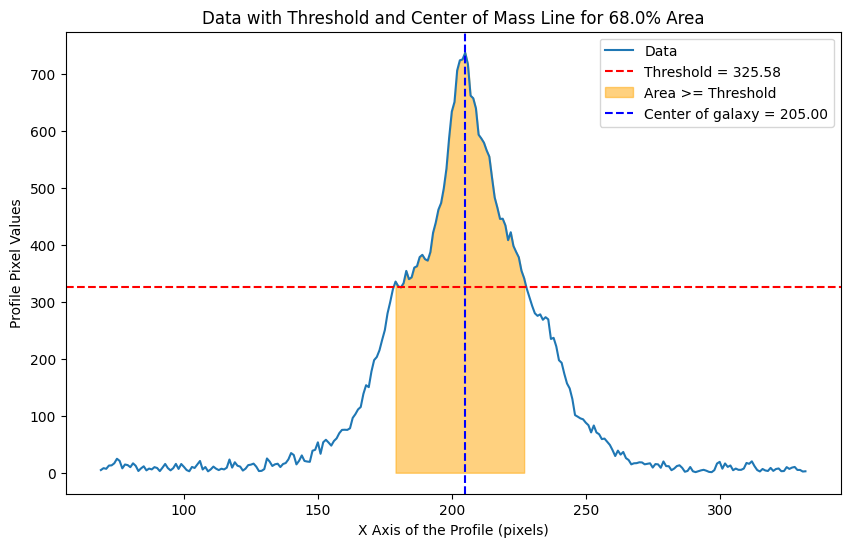

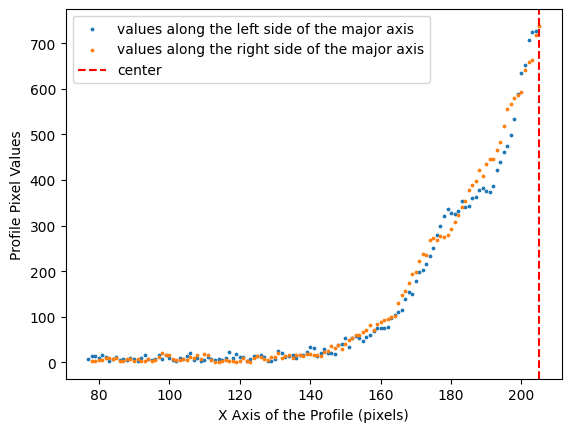

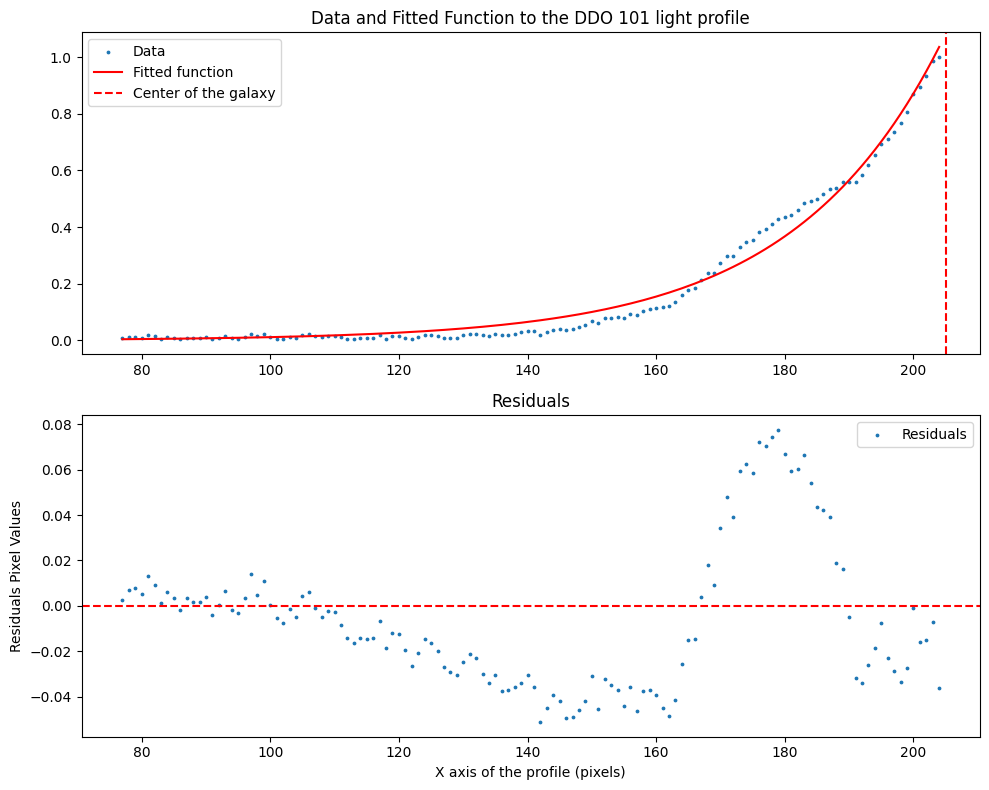

Exponential fit function is a * exp(b * (x - x0)) + c
b is 0.0432 +/- 0.0008
x0 is 203.1789 +/- 0.2769
RD is 23.1531 pixels
RD for DDO 101 is 1.1456153070637087 kpc


In [42]:
galaxy_name = "DDO 101"
D = 9
x_start = 225
y_start = 300
a_half = 33
b_half = 21
theta_deg = 18.69986989
X_center = 201
y_center = 201
n = 4

theta_rad = np.radians(theta_deg)
list_of_ellipse_data = [theta_rad , a_half, b_half]
 
visual_101 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO101\non_shifted_background_d101v.fits"))
visual_101 = visual_101[y_start:y_start + int(2 * X_center), x_start: int(x_start + 2 * y_center)]

x_ax_left = np.arange(X_center - n*a_half, X_center)
x_ax_right = np.arange(X_center, X_center + n*a_half)
x_ax = np.concatenate((x_ax_left, x_ax_right))
theta_rad = np.radians(theta_deg)

def get_line_values(array, X_center, y_center, x_ax, theta_rad): 
        m = np.tan(theta_rad)
        values = [] 
        y_list = [] 
        for x in x_ax: 
            y = int(m * (x) + y_center - m*X_center) 
            values.append(array[y, x]) 
            array[y, x] = 3000 
            y_list.append(y) 
        return values, y_list

get_line_values(visual_101, X_center, y_center, x_ax, theta_rad)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(visual_101, cmap='gray', origin='lower')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(" ")

plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.legend()
plt.show()

DDO_101 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO101\non_shifted_background_d101v.fits"))
DDO_101 = DDO_101[y_start:y_start + int(2 * X_center), x_start: int(x_start + 2 * y_center)]

def RD(n, image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, galaxy_name, ratio=0.68, initial_guesses=[0.006, 25]):
    theta_rad, a, b = list_of_ellipse_data
    
    def get_line_values(array, X_center, y_center, x_ax, theta_rad): 
        m = np.tan(theta_rad)
        values = [] 
        y_list = [] 
        for x in x_ax: 
            y = int(m * (x) + y_center - m*X_center) 
            combined_value = 0.5* float(array[y,x]) + (1/8)*(float(array[y-1,x])+float(array[y+1,x])+float(array[y,x-1])+float(array[y,x+1]))
            values.append(combined_value) 
            y_list.append(y) 
        return values, y_list
        
    center_of_galaxy_x = int(center_of_galaxy_x)
    
    x_ax_left = np.arange(X_center - n*a_half, X_center)
    x_ax_right = np.arange(X_center, X_center + n*a_half)

    values_along_line_left, y_list_left = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y,x_ax_left, theta_rad)
    values_along_line_right, y_list_right = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y,x_ax_right ,theta_rad)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))

    # Add print statements to debug the lengths
    print(f"x_ax_left length: {len(x_ax_left)}")
    print(f"x_ax_right length: {len(x_ax_right)}")
    print(f"values_along_line_left length: {len(values_along_line_left)}")
    print(f"values_along_line_right length: {len(values_along_line_right)}")

    print(f"x_ax combined length: {len(x_ax)}")
    print(f"values_along_line combined length: {len(values_along_line)}")

        
    if len(x_ax) == len(values_along_line):
        plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
        plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
        plt.title(f"Light profile for {galaxy_name} along the major axis.")
        plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
        plt.xlabel("X Axis of the Profile (pixels)")
        plt.ylabel("Profile Pixel Values")
        plt.legend()
        plt.show()
    else:
        print("The lengths of x_ax and values_along_line do not match.")
        print(len(x_ax))
        print(len(values_along_line))
        return
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    x_ax_left = x_ax[:com_index]
    x_ax_right = x_ax[com_index:]

    if len(x_ax_left) > len(x_ax_right):
        delete = len(x_ax_left) - len(x_ax_right)
        x_ax_left = x_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(x_ax_left) < len(x_ax_right):
        delete = len(x_ax_right) - len(x_ax_left)
        x_ax_right = x_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    flipped_x_ax_right = []
    for i in range(len(x_ax_right)):
        x = (2 * center_of_mass_x - x_ax_right[i])
        flipped_x_ax_right.append(int(x))

    flipped_x_ax_right = np.array(flipped_x_ax_right)

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='center')
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.legend()
    plt.show()
    
    x1 = x_ax_left  
    x2 = flipped_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2)/2
    mean_y_normal = mean_y/np.max(mean_y)
    def exponential_func(x,b,x0):
        return np.exp(b * (x - x0))

    popt, pcov = curve_fit(exponential_func, x_ax_left, mean_y_normal, p0=initial_guesses)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_ax_left, mean_y_normal, s=3, label='Data')
    plt.plot(x_ax_left, exponential_func(x_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y_normal - exponential_func(x_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(x_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('X axis of the profile (pixels)') 
    plt.ylabel('Residuals Pixel Values') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    
    print(f"b is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"x0 is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"RD is {1/popt[0]:.4f} pixels")
    
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((distance * RD_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD_value} kpc")

    return RD_pixels , RD_arcsec, mean_y, x_ax_left
RD_pixels , RD_arcsec , y_values , x_values = RD(4, DDO_101, D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name, initial_guesses=[0.006, 25])

128 128


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_43404\1115952597.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(b * (x - x0))


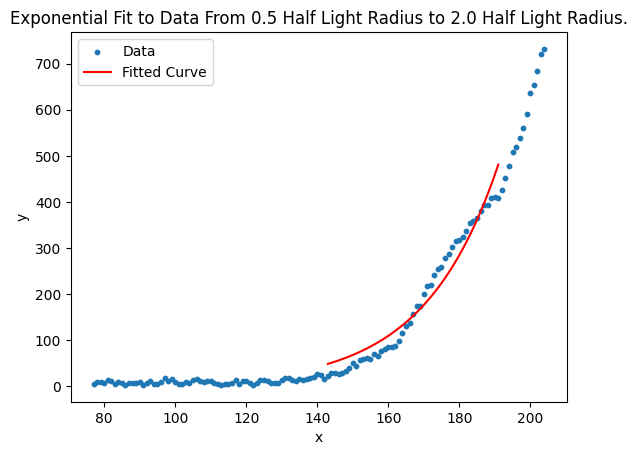

RD for DDO 101 is 1.0347355010359658 kpc for 0.5 Half Light Radius to 2.0 Half Light Radius 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_43404\1115952597.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(b * (x - x0))


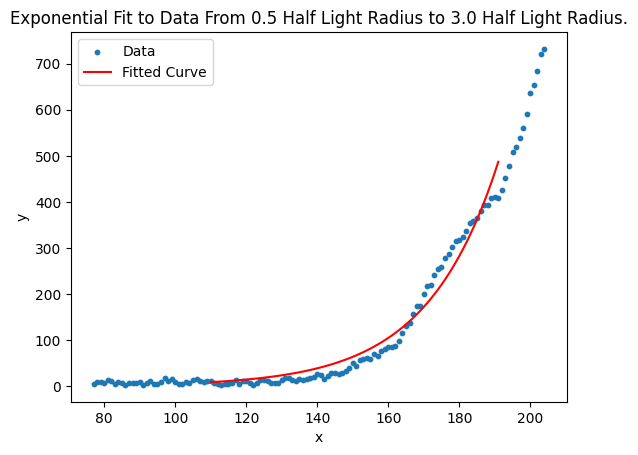

RD for DDO 101 is 0.9977279583029512 kpc for 0.5 Half Light Radius to 3.0 Half Light Radius 


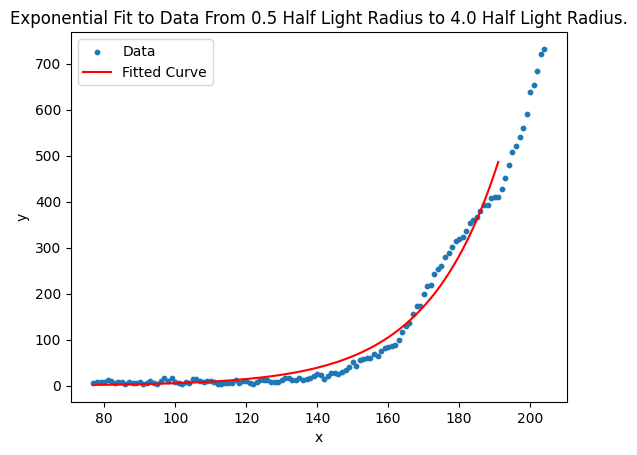

RD for DDO 101 is 1.0009261054531027 kpc for 0.5 Half Light Radius to 4.0 Half Light Radius 


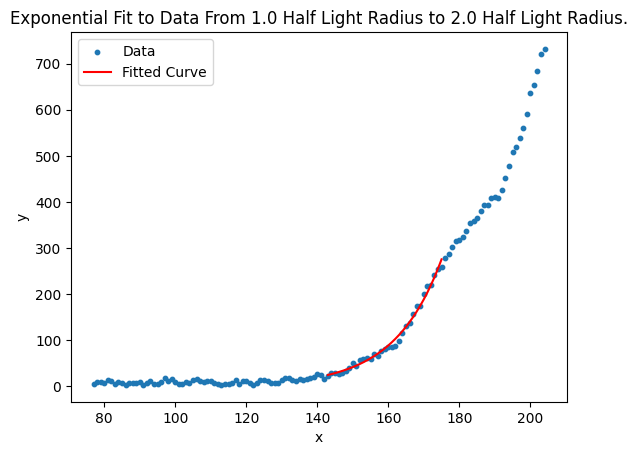

RD for DDO 101 is 0.6536182205496819 kpc for 1.0 Half Light Radius to 2.0 Half Light Radius 


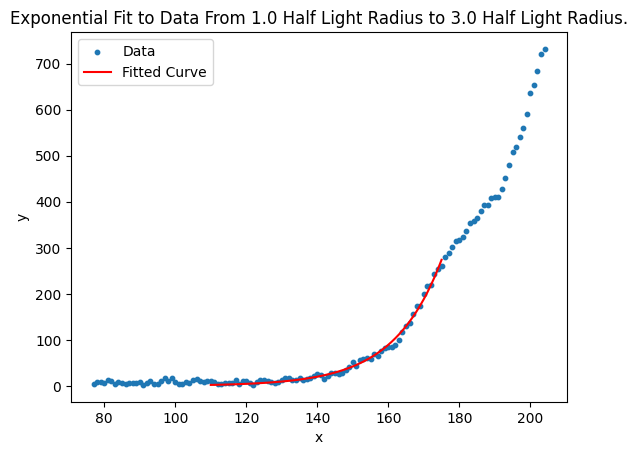

RD for DDO 101 is 0.662438607658499 kpc for 1.0 Half Light Radius to 3.0 Half Light Radius 


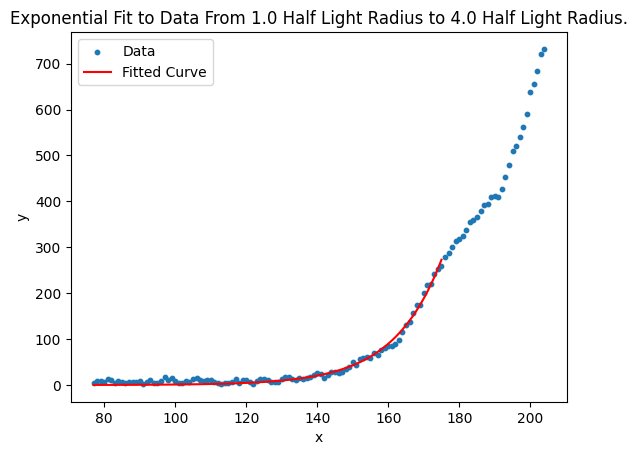

RD for DDO 101 is 0.6680285224737073 kpc for 1.0 Half Light Radius to 4.0 Half Light Radius 


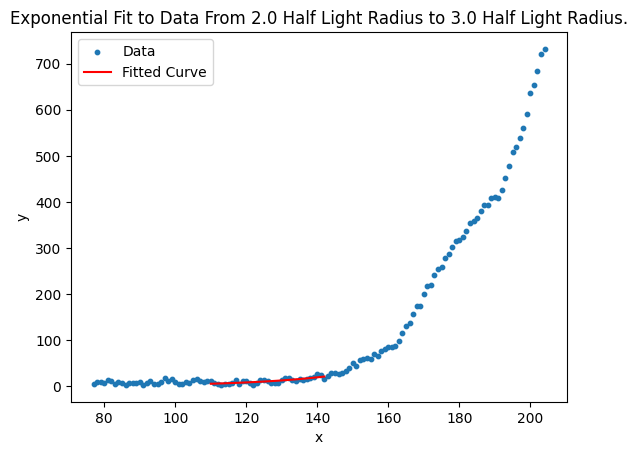

RD for DDO 101 is 1.1551962780837808 kpc for 2.0 Half Light Radius to 3.0 Half Light Radius 


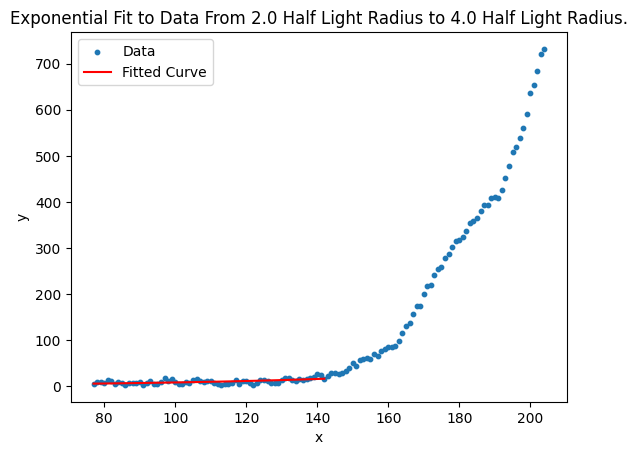

RD for DDO 101 is 3.016947705740379 kpc for 2.0 Half Light Radius to 4.0 Half Light Radius 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_43404\1115952597.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(b * (x - x0))


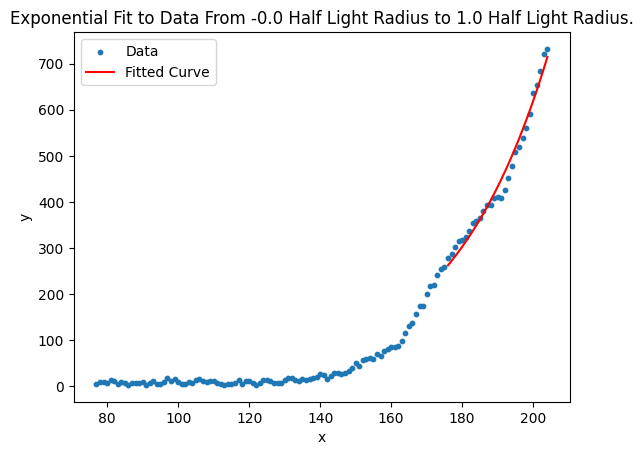

RD for DDO 101 is 1.3825358212376566 kpc for -0.0 Half Light Radius to 1.0 Half Light Radius 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_43404\1115952597.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(b * (x - x0))


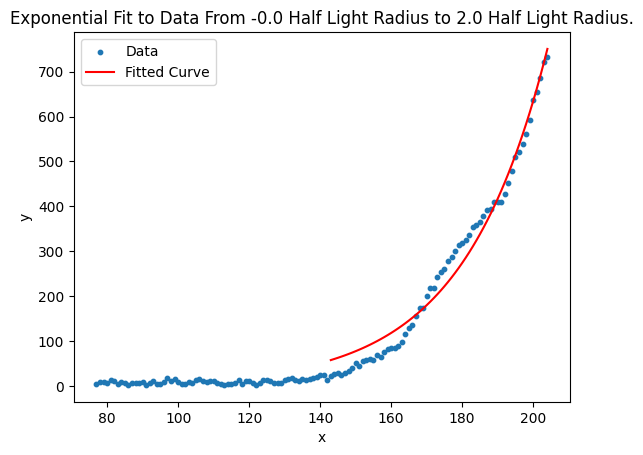

RD for DDO 101 is 1.1792095816646764 kpc for -0.0 Half Light Radius to 2.0 Half Light Radius 


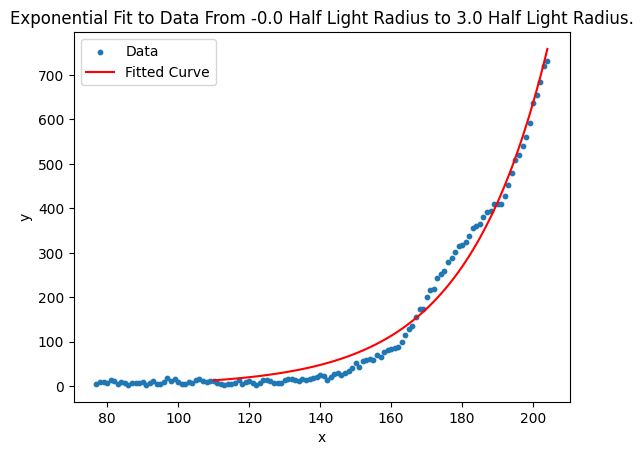

RD for DDO 101 is 1.1449191883441716 kpc for -0.0 Half Light Radius to 3.0 Half Light Radius 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_43404\1115952597.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(b * (x - x0))


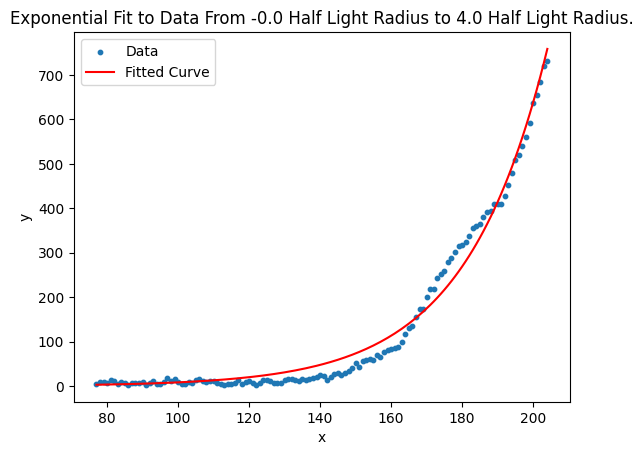

RD for DDO 101 is 1.1456145318651285 kpc for -0.0 Half Light Radius to 4.0 Half Light Radius 
   Range (half light)  RD (kpc)       RMSE
0          0.5 - 2.0   1.034736  28.686264
1           0.5 - 3.0  0.997728  23.654534
2           0.5 - 4.0  1.000926  20.200492
3           1.0 - 2.0  0.653618   6.949884
4           1.0 - 3.0  0.662439   5.866129
5           1.0 - 4.0  0.668029   6.883418
6           2.0 - 3.0  1.155196   3.362006
7           2.0 - 4.0  3.016948   4.069587
8             0.0 - 1  1.382536  18.968376
9           0.0 - 2.0  1.179210  30.245304
10          0.0 - 3.0  1.144919  27.047885
11          0.0 - 4.0  1.145615  23.400863
Paper value 1.32 kpc


In [43]:
def exponential_func(x, b, x0):
    return np.exp(b * (x - x0))

from sklearn.metrics import mean_squared_error
pixel_scale = 1.134

bounds = [[4-2, 4-0.5], [4-3,4-0.5], [4-4, 4-0.5], [4-2, 4-1], [4-3,4-1], [4-4, 4-1], [4-3,4-2], [4-4, 4-2] ,[4-1, 4-0], [4-2, 4-0], [4-3,4-0], [4-4, 4-0]]
print(len(y_values) , len(x_values))
RD_list = []
RMSE_list = []
for bound in bounds:
    lower_bound = float(bound[0])
    higher_bound = float(bound[1])
    x_filtered = x_values[int(lower_bound*a_half) : int(higher_bound * a_half)]
    y_filtered = y_values[int(lower_bound*a_half) : int(higher_bound * a_half)]


    popt, pcov = curve_fit(exponential_func, x_filtered, y_filtered, p0=[0.006, 25])
    y_pred = exponential_func(x_filtered, *popt) 
    rmse = np.sqrt(mean_squared_error(y_filtered, y_pred)) 
    RMSE_list.append(rmse)
    # Plot the results
    plt.scatter(x_values, y_values, label='Data', s=10)
    plt.plot(x_filtered, exponential_func(x_filtered, *popt), 'r-', label='Fitted Curve')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Exponential Fit to Data From {-(higher_bound-4)} Half Light Radius to {-(lower_bound-4)} Half Light Radius.')
    plt.show()
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((D * RD_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD_value} kpc for {-(higher_bound-4)} Half Light Radius to {-(lower_bound-4)} Half Light Radius ")
    RD_list.append(RD_value)
import pandas as pd

# Create a dictionary of data
data = {
    'Range (half light)': [' 0.5 - 2.0 ', '0.5 - 3.0', '0.5 - 4.0', '1.0 - 2.0', '1.0 - 3.0', '1.0 - 4.0', '2.0 - 3.0', '2.0 - 4.0','0.0 - 1', '0.0 - 2.0' , '0.0 - 3.0', '0.0 - 4.0'],
    'RD (kpc)': RD_list,
    'RMSE' : RMSE_list
    
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame as a table
print(df)

print("Paper value 1.32 kpc")


x_ax_left length: 99
x_ax_right length: 99
values_along_line_left length: 99
values_along_line_right length: 99
x_ax combined length: 198
values_along_line combined length: 198


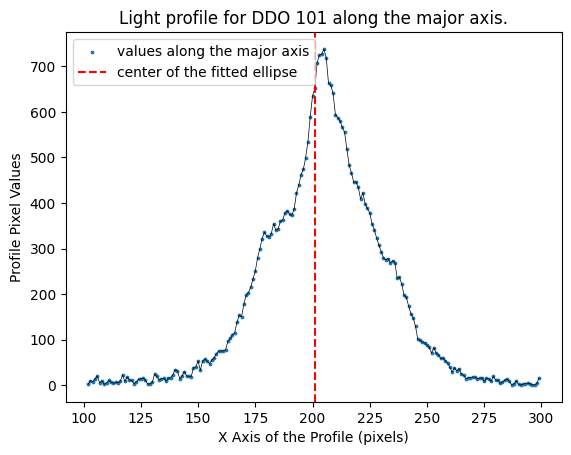

Threshold value: 327.7069308592835
Center of galaxy (Equal Area on both sides of the center line): 205


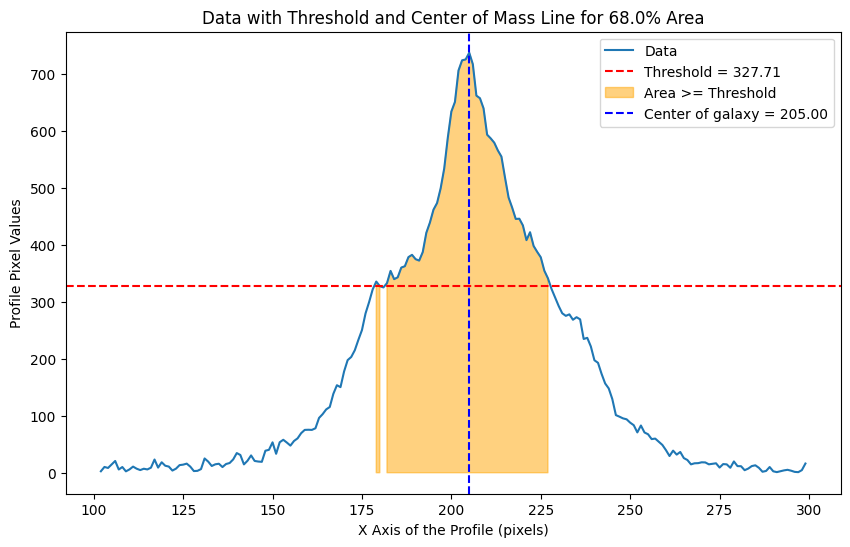

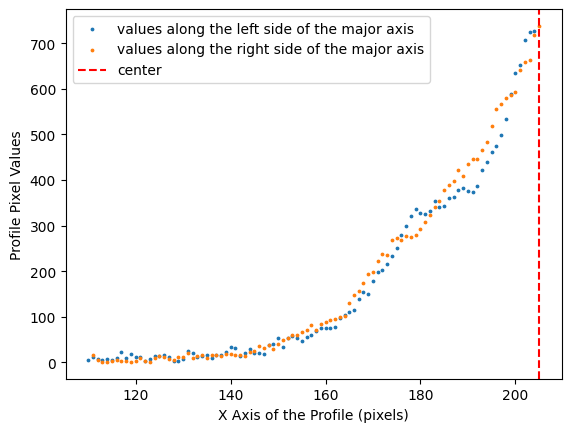

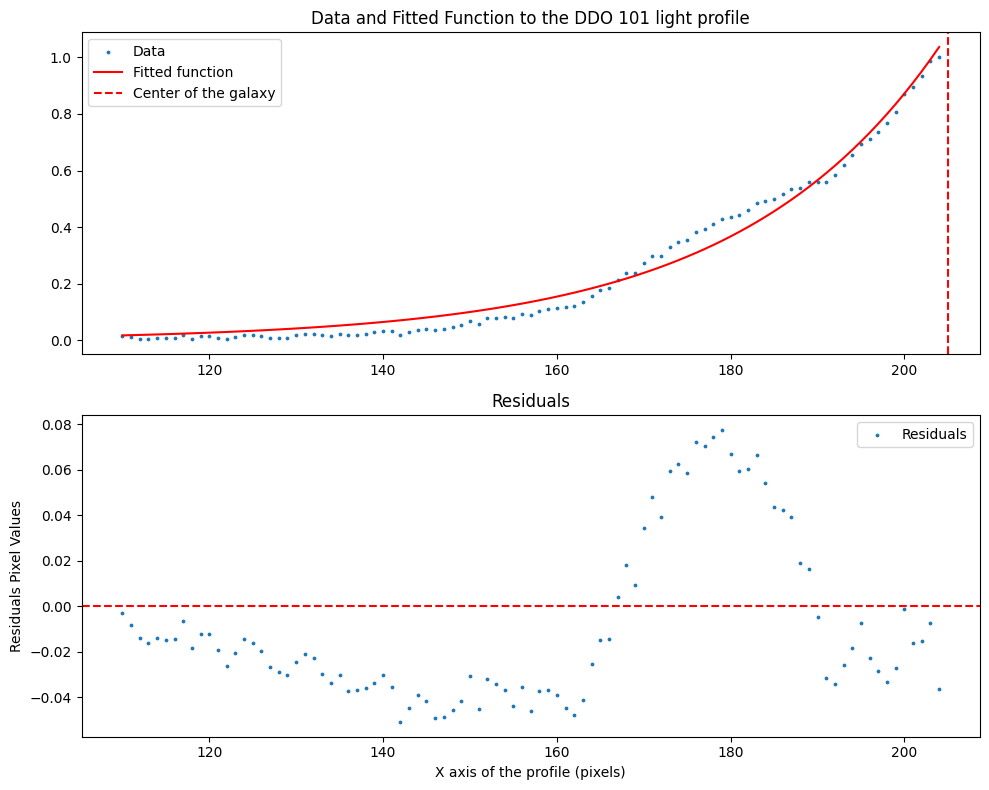

Exponential fit function is a * exp(b * (x - x0)) + c
b is 0.0432 +/- 0.0009
x0 is 203.1735 +/- 0.3216
RD is 23.1391 pixels
RD for DDO 101 is 1.1449214207780953 kpc


In [44]:
RD_pixels , RD_arcsec , y_values , x_values = RD(3, DDO_101, D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name, initial_guesses=[0.006, 25])

sigma is 48.53180214830747
RD values: [1.1629135259103156, 1.123830185240187, 1.155664659129414, 1.123357485597746, 1.1687746780800048, 1.1467838030546402, 1.1411787015249395, 1.0986430985722446, 1.1416843154108052, 1.1868401240146516, 1.1015367032073042, 1.1552485408771804, 1.1725927328276944, 1.0982745730968657, 1.1424692236793754, 1.159094877369499, 1.185788115584823, 1.1431370559789023, 1.2272619076313291, 1.1338312131389712, 1.1304035523588387, 1.154467703959802, 1.139474904818763, 1.1748647250692725, 1.1641505843469233, 1.0979813985490032, 1.0796892986610496, 1.1831421113152727, 1.1701381883336495, 1.092008600350135, 1.1491904068085483, 1.1288850020565544, 1.1803655472278807, 1.1250695887816504, 1.1403790182517908, 1.090621619468117, 1.1107765964367486, 1.1790909004343773, 1.0695708029070161, 1.1882518244043652, 1.1458582460765931, 1.1633977311445103, 1.1263460405476733, 1.1824238081237897, 1.1486294858521306, 1.1583154200176637, 1.0798233593022377, 1.1918487666119588, 1.22976855

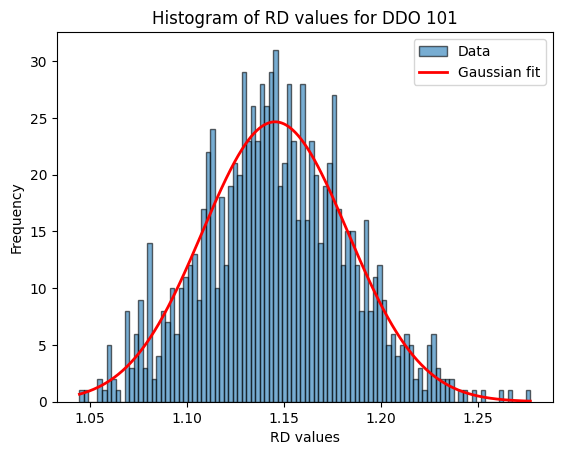

Fitted parameters: A=24.650429817656708, mu=1.1454435957778384, sigma=0.037439352236604016
RD for DDO 101 is 1.145 +/- 0.037


In [45]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential_func(x, b, x0):
    return np.exp(b * (x - x0))

# Assume DDO_101 and y_values are defined
sigma = np.std(DDO_101)
print("sigma is" ,sigma)

# Number of iterations
n = 1000

# Lists to store the fitted parameters
b_list = []
x0_list = []
RD_list = []

# Loop for bootstrapping
for i in range(n):
    # Generate unique random noise for each data point from the normal distribution
    noise = np.random.normal(0, sigma, size=len(y_values))
    # Add unique noise to each data point in y_values
    y_noisy = y_values + noise
    y_noisy_normal = y_noisy / np.max(y_noisy)
    # Fit the exponential function to the noisy data
    popt, pcov = curve_fit(exponential_func, x_values, y_noisy_normal, p0=(0.006, 25))
    
    # Append the parameters to the respective lists
    b_list.append(popt[0])
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * 1.134
    RD_value = ((D * RD_arcsec) / 206265)*1000
    RD_list.append(RD_value)
    
    x0_list.append(popt[1])



print(f"RD values: {RD_list}")
# Define the Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Generate histogram data
counts, bin_edges = np.histogram(RD_list, bins=100)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guess for the parameters (A, mu, sigma)
initial_guess = [max(counts), np.mean(RD_list), np.std(RD_list)]

# Fit the Gaussian function to the histogram data
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)

# Plot the histogram
plt.hist(RD_list, bins=100, edgecolor='k', alpha=0.6, label='Data')

# Plot the fitted Gaussian curve
x_fit = np.linspace(min(RD_list), max(RD_list), 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Gaussian fit')

# Add labels and title
plt.xlabel('RD values')
plt.ylabel('Frequency')
plt.title(f'Histogram of RD values for {galaxy_name}')
plt.legend()

# Show the plot
plt.show()

# Print the fitted parameters
print(f"Fitted parameters: A={popt[0]}, mu={popt[1]}, sigma={popt[2]}")
rd_value = f"{popt[1]:.3f}" 
rd_error = f"{popt[2]:.3f}"  

print(f"RD for {galaxy_name} is {rd_value} +/- {rd_error}")
